In [34]:
import pandas as pd
from data_mountain_query.query import get_ambient_tweets
from data_mountain_query.connection import get_connection
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import timedelta
import plotly.express as px

In [35]:
games = pd.read_csv("/Users/elisabethkollrack/Thesis/EK-thesis/games.csv")
games = games[games['game_type'] == 'REG']
games['gameday'] = pd.to_datetime(games['gameday'], format='%m/%d/%y')

# Dallas 2013 games
ne_games = games[
    (games['season'] >= 2013) & (games['season'] <= 2017) &
    ((games['home_team'] == 'NE') | (games['away_team'] == 'NE'))
].sort_values(['season', 'gameday'])


In [36]:
collection, client = get_connection(geotweets=True)

Connecting on mgmt1.vacc.uvm.edu


In [37]:
all_tweets = []
for index, game in ne_games.iterrows():
    gameday = game['gameday']
    
    # Determine opponent
    if game['home_team'] == 'NE':
        opponent = game['away_team']
    else:
        opponent = game['home_team']

    anchors = [
        "#newenglandpatriots", 
        "#patriots",
        "NEPats"
        f"#NEvs{opponent}",
        f"#{opponent}vsNE"
    ]

    start_date = gameday - timedelta(days=3)
    end_date = gameday + timedelta(days=3)
    dates = pd.date_range(start_date, end_date, freq='D')

    for anchor in anchors:
        tweets_list1 = [t for t in get_ambient_tweets(anchor, dates, collection)]
        all_tweets.extend(tweets_list1)



{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-05 00:00:00'), '$lt': Timestamp('2013-09-11 00:00:00')}, 'fastText_lang': 'en'}


  0%|          | 0/2 [00:00<?, ?it/s]/opt/anaconda3/envs/data-mountain-query/lib/python3.9/site-packages/pymongo/synchronous/collection.py:1945: UserWarning:

use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout

100%|██████████| 2/2 [00:00<00:00, 21.54it/s]

{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-05 00:00:00'), '$lt': Timestamp('2013-09-11 00:00:00')}, 'fastText_lang': 'en'}



100%|██████████| 129/129 [00:00<00:00, 188.99it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-05 00:00:00'), '$lt': Timestamp('2013-09-11 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-05 00:00:00'), '$lt': Timestamp('2013-09-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.65it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-09 00:00:00'), '$lt': Timestamp('2013-09-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.33it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-09 00:00:00'), '$lt': Timestamp('2013-09-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 176/176 [00:00<00:00, 368.92it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-09 00:00:00'), '$lt': Timestamp('2013-09-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-09 00:00:00'), '$lt': Timestamp('2013-09-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 39/39 [00:00<00:00, 380.14it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-19 00:00:00'), '$lt': Timestamp('2013-09-25 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-19 00:00:00'), '$lt': Timestamp('2013-09-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 48/48 [00:00<00:00, 250.22it/s]


{'$text': {'$search': '"NEPats#NEvsTB"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-19 00:00:00'), '$lt': Timestamp('2013-09-25 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#TBvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-19 00:00:00'), '$lt': Timestamp('2013-09-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.37it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-26 00:00:00'), '$lt': Timestamp('2013-10-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 41.99it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-26 00:00:00'), '$lt': Timestamp('2013-10-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 123/123 [00:00<00:00, 219.78it/s]


{'$text': {'$search': '"NEPats#NEvsATL"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-26 00:00:00'), '$lt': Timestamp('2013-10-02 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#ATLvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-09-26 00:00:00'), '$lt': Timestamp('2013-10-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 104.99it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-03 00:00:00'), '$lt': Timestamp('2013-10-09 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-03 00:00:00'), '$lt': Timestamp('2013-10-09 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 66/66 [00:00<00:00, 231.32it/s]


{'$text': {'$search': '"NEPats#NEvsCIN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-03 00:00:00'), '$lt': Timestamp('2013-10-09 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CINvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-03 00:00:00'), '$lt': Timestamp('2013-10-09 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-10 00:00:00'), '$lt': Timestamp('2013-10-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 42.77it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-10 00:00:00'), '$lt': Timestamp('2013-10-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 184/184 [00:00<00:00, 361.78it/s]


{'$text': {'$search': '"NEPats#NEvsNO"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-10 00:00:00'), '$lt': Timestamp('2013-10-16 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NOvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-10 00:00:00'), '$lt': Timestamp('2013-10-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 82/82 [00:00<00:00, 411.94it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-17 00:00:00'), '$lt': Timestamp('2013-10-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 19.27it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-17 00:00:00'), '$lt': Timestamp('2013-10-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 93/93 [00:00<00:00, 338.86it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-17 00:00:00'), '$lt': Timestamp('2013-10-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-17 00:00:00'), '$lt': Timestamp('2013-10-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-24 00:00:00'), '$lt': Timestamp('2013-10-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.22it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-24 00:00:00'), '$lt': Timestamp('2013-10-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 72/72 [00:00<00:00, 258.43it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-24 00:00:00'), '$lt': Timestamp('2013-10-30 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-24 00:00:00'), '$lt': Timestamp('2013-10-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 16/16 [00:00<00:00, 165.51it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-31 00:00:00'), '$lt': Timestamp('2013-11-06 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 19.62it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-31 00:00:00'), '$lt': Timestamp('2013-11-06 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 58/58 [00:00<00:00, 304.18it/s]


{'$text': {'$search': '"NEPats#NEvsPIT"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-31 00:00:00'), '$lt': Timestamp('2013-11-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#PITvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-10-31 00:00:00'), '$lt': Timestamp('2013-11-06 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 17/17 [00:00<00:00, 176.64it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-15 00:00:00'), '$lt': Timestamp('2013-11-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 49.63it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-15 00:00:00'), '$lt': Timestamp('2013-11-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 107/107 [00:00<00:00, 281.12it/s]


{'$text': {'$search': '"NEPats#NEvsCAR"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-15 00:00:00'), '$lt': Timestamp('2013-11-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CARvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-15 00:00:00'), '$lt': Timestamp('2013-11-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 15/15 [00:00<00:00, 152.52it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-21 00:00:00'), '$lt': Timestamp('2013-11-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 30.46it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-21 00:00:00'), '$lt': Timestamp('2013-11-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 379/379 [00:00<00:00, 566.67it/s]


{'$text': {'$search': '"NEPats#NEvsDEN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-21 00:00:00'), '$lt': Timestamp('2013-11-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DENvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-21 00:00:00'), '$lt': Timestamp('2013-11-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 283/283 [00:00<00:00, 575.32it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-28 00:00:00'), '$lt': Timestamp('2013-12-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.91it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-28 00:00:00'), '$lt': Timestamp('2013-12-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 86/86 [00:00<00:00, 306.39it/s]


{'$text': {'$search': '"NEPats#NEvsHOU"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-28 00:00:00'), '$lt': Timestamp('2013-12-04 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#HOUvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-11-28 00:00:00'), '$lt': Timestamp('2013-12-04 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-05 00:00:00'), '$lt': Timestamp('2013-12-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 61.23it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-05 00:00:00'), '$lt': Timestamp('2013-12-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 178/178 [00:00<00:00, 376.76it/s]


{'$text': {'$search': '"NEPats#NEvsCLE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-05 00:00:00'), '$lt': Timestamp('2013-12-11 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CLEvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-05 00:00:00'), '$lt': Timestamp('2013-12-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 57/57 [00:00<00:00, 558.59it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-12 00:00:00'), '$lt': Timestamp('2013-12-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.25it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-12 00:00:00'), '$lt': Timestamp('2013-12-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 104/104 [00:00<00:00, 260.82it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-12 00:00:00'), '$lt': Timestamp('2013-12-18 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-12 00:00:00'), '$lt': Timestamp('2013-12-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 103.98it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-19 00:00:00'), '$lt': Timestamp('2013-12-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 105.79it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-19 00:00:00'), '$lt': Timestamp('2013-12-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 116/116 [00:00<00:00, 307.43it/s]


{'$text': {'$search': '"NEPats#NEvsBAL"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-19 00:00:00'), '$lt': Timestamp('2013-12-25 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BALvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-19 00:00:00'), '$lt': Timestamp('2013-12-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 41.32it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-26 00:00:00'), '$lt': Timestamp('2014-01-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.83it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-26 00:00:00'), '$lt': Timestamp('2014-01-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 83/83 [00:00<00:00, 111.69it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-26 00:00:00'), '$lt': Timestamp('2014-01-01 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2013-12-26 00:00:00'), '$lt': Timestamp('2014-01-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 24/24 [00:00<00:00, 253.29it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-04 00:00:00'), '$lt': Timestamp('2014-09-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 101.52it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-04 00:00:00'), '$lt': Timestamp('2014-09-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 170/170 [00:00<00:00, 351.22it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-04 00:00:00'), '$lt': Timestamp('2014-09-10 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-04 00:00:00'), '$lt': Timestamp('2014-09-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 9/9 [00:00<00:00, 96.92it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-11 00:00:00'), '$lt': Timestamp('2014-09-17 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 64.61it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-11 00:00:00'), '$lt': Timestamp('2014-09-17 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 105/105 [00:00<00:00, 271.75it/s]


{'$text': {'$search': '"NEPats#NEvsMIN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-11 00:00:00'), '$lt': Timestamp('2014-09-17 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MINvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-11 00:00:00'), '$lt': Timestamp('2014-09-17 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 53.68it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-18 00:00:00'), '$lt': Timestamp('2014-09-24 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-18 00:00:00'), '$lt': Timestamp('2014-09-24 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 62/62 [00:00<00:00, 229.11it/s]


{'$text': {'$search': '"NEPats#NEvsOAK"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-18 00:00:00'), '$lt': Timestamp('2014-09-24 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#OAKvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-18 00:00:00'), '$lt': Timestamp('2014-09-24 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 27/27 [00:00<00:00, 284.71it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-26 00:00:00'), '$lt': Timestamp('2014-10-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 47.34it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-26 00:00:00'), '$lt': Timestamp('2014-10-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 98/98 [00:00<00:00, 343.21it/s]


{'$text': {'$search': '"NEPats#NEvsKC"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-26 00:00:00'), '$lt': Timestamp('2014-10-02 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#KCvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-09-26 00:00:00'), '$lt': Timestamp('2014-10-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 23/23 [00:00<00:00, 236.11it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-02 00:00:00'), '$lt': Timestamp('2014-10-08 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 7/7 [00:00<00:00, 75.68it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-02 00:00:00'), '$lt': Timestamp('2014-10-08 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 134/134 [00:00<00:00, 350.58it/s]


{'$text': {'$search': '"NEPats#NEvsCIN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-02 00:00:00'), '$lt': Timestamp('2014-10-08 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CINvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-02 00:00:00'), '$lt': Timestamp('2014-10-08 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 54/54 [00:00<00:00, 530.36it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-09 00:00:00'), '$lt': Timestamp('2014-10-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 37.16it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-09 00:00:00'), '$lt': Timestamp('2014-10-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 75/75 [00:00<00:00, 271.39it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-09 00:00:00'), '$lt': Timestamp('2014-10-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-09 00:00:00'), '$lt': Timestamp('2014-10-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 38.13it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-13 00:00:00'), '$lt': Timestamp('2014-10-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 43.01it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-13 00:00:00'), '$lt': Timestamp('2014-10-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 99/99 [00:00<00:00, 348.42it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-13 00:00:00'), '$lt': Timestamp('2014-10-19 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-13 00:00:00'), '$lt': Timestamp('2014-10-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 53/53 [00:00<00:00, 533.38it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-23 00:00:00'), '$lt': Timestamp('2014-10-29 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.35it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-23 00:00:00'), '$lt': Timestamp('2014-10-29 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 81/81 [00:00<00:00, 298.09it/s]


{'$text': {'$search': '"NEPats#NEvsCHI"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-23 00:00:00'), '$lt': Timestamp('2014-10-29 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CHIvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-23 00:00:00'), '$lt': Timestamp('2014-10-29 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 53/53 [00:00<00:00, 517.67it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-30 00:00:00'), '$lt': Timestamp('2014-11-05 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 103.83it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-30 00:00:00'), '$lt': Timestamp('2014-11-05 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 134/134 [00:00<00:00, 349.28it/s]


{'$text': {'$search': '"NEPats#NEvsDEN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-30 00:00:00'), '$lt': Timestamp('2014-11-05 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DENvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-10-30 00:00:00'), '$lt': Timestamp('2014-11-05 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 127/127 [00:00<00:00, 410.47it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-13 00:00:00'), '$lt': Timestamp('2014-11-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.43it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-13 00:00:00'), '$lt': Timestamp('2014-11-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 112/112 [00:00<00:00, 285.98it/s]


{'$text': {'$search': '"NEPats#NEvsIND"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-13 00:00:00'), '$lt': Timestamp('2014-11-19 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#INDvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-13 00:00:00'), '$lt': Timestamp('2014-11-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 7/7 [00:00<00:00, 70.40it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-20 00:00:00'), '$lt': Timestamp('2014-11-26 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.90it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-20 00:00:00'), '$lt': Timestamp('2014-11-26 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 88/88 [00:00<00:00, 313.71it/s]


{'$text': {'$search': '"NEPats#NEvsDET"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-20 00:00:00'), '$lt': Timestamp('2014-11-26 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DETvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-20 00:00:00'), '$lt': Timestamp('2014-11-26 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 53/53 [00:00<00:00, 501.30it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-27 00:00:00'), '$lt': Timestamp('2014-12-03 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 65.60it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-27 00:00:00'), '$lt': Timestamp('2014-12-03 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 111/111 [00:00<00:00, 292.58it/s]


{'$text': {'$search': '"NEPats#NEvsGB"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-27 00:00:00'), '$lt': Timestamp('2014-12-03 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#GBvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-11-27 00:00:00'), '$lt': Timestamp('2014-12-03 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 43/43 [00:00<00:00, 410.33it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-04 00:00:00'), '$lt': Timestamp('2014-12-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 9/9 [00:00<00:00, 96.31it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-04 00:00:00'), '$lt': Timestamp('2014-12-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 109/109 [00:00<00:00, 230.56it/s]


{'$text': {'$search': '"NEPats#NEvsSD"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-04 00:00:00'), '$lt': Timestamp('2014-12-10 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#SDvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-04 00:00:00'), '$lt': Timestamp('2014-12-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 19/19 [00:00<00:00, 194.70it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-11 00:00:00'), '$lt': Timestamp('2014-12-17 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 64.02it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-11 00:00:00'), '$lt': Timestamp('2014-12-17 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 78/78 [00:00<00:00, 279.08it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-11 00:00:00'), '$lt': Timestamp('2014-12-17 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-11 00:00:00'), '$lt': Timestamp('2014-12-17 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 33/33 [00:00<00:00, 338.75it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-18 00:00:00'), '$lt': Timestamp('2014-12-24 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 62.13it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-18 00:00:00'), '$lt': Timestamp('2014-12-24 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 69/69 [00:00<00:00, 244.27it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-18 00:00:00'), '$lt': Timestamp('2014-12-24 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-18 00:00:00'), '$lt': Timestamp('2014-12-24 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.06it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-25 00:00:00'), '$lt': Timestamp('2014-12-31 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 30.68it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-25 00:00:00'), '$lt': Timestamp('2014-12-31 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 34/34 [00:00<00:00, 181.82it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-25 00:00:00'), '$lt': Timestamp('2014-12-31 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2014-12-25 00:00:00'), '$lt': Timestamp('2014-12-31 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 14/14 [00:00<00:00, 150.32it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-07 00:00:00'), '$lt': Timestamp('2015-09-13 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 41.71it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-07 00:00:00'), '$lt': Timestamp('2015-09-13 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 36/36 [00:00<00:00, 203.42it/s]


{'$text': {'$search': '"NEPats#NEvsPIT"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-07 00:00:00'), '$lt': Timestamp('2015-09-13 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#PITvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-07 00:00:00'), '$lt': Timestamp('2015-09-13 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 18/18 [00:00<00:00, 186.18it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-17 00:00:00'), '$lt': Timestamp('2015-09-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.56it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-17 00:00:00'), '$lt': Timestamp('2015-09-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 12/12 [00:00<00:00, 67.81it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-17 00:00:00'), '$lt': Timestamp('2015-09-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-17 00:00:00'), '$lt': Timestamp('2015-09-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-24 00:00:00'), '$lt': Timestamp('2015-09-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 51.27it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-24 00:00:00'), '$lt': Timestamp('2015-09-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 17/17 [00:00<00:00, 95.97it/s]


{'$text': {'$search': '"NEPats#NEvsJAX"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-24 00:00:00'), '$lt': Timestamp('2015-09-30 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#JAXvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-09-24 00:00:00'), '$lt': Timestamp('2015-09-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.54it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-08 00:00:00'), '$lt': Timestamp('2015-10-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-08 00:00:00'), '$lt': Timestamp('2015-10-14 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 23/23 [00:00<00:00, 131.34it/s]


{'$text': {'$search': '"NEPats#NEvsDAL"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-08 00:00:00'), '$lt': Timestamp('2015-10-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DALvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-08 00:00:00'), '$lt': Timestamp('2015-10-14 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.90it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-15 00:00:00'), '$lt': Timestamp('2015-10-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 11.03it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-15 00:00:00'), '$lt': Timestamp('2015-10-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 21/21 [00:00<00:00, 120.78it/s]


{'$text': {'$search': '"NEPats#NEvsIND"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-15 00:00:00'), '$lt': Timestamp('2015-10-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#INDvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-15 00:00:00'), '$lt': Timestamp('2015-10-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-22 00:00:00'), '$lt': Timestamp('2015-10-28 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.90it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-22 00:00:00'), '$lt': Timestamp('2015-10-28 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 34.52it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-22 00:00:00'), '$lt': Timestamp('2015-10-28 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-22 00:00:00'), '$lt': Timestamp('2015-10-28 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.15it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-26 00:00:00'), '$lt': Timestamp('2015-11-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 42.40it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-26 00:00:00'), '$lt': Timestamp('2015-11-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 21/21 [00:00<00:00, 118.23it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-26 00:00:00'), '$lt': Timestamp('2015-11-01 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-10-26 00:00:00'), '$lt': Timestamp('2015-11-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 9/9 [00:00<00:00, 90.01it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-05 00:00:00'), '$lt': Timestamp('2015-11-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.99it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-05 00:00:00'), '$lt': Timestamp('2015-11-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 7/7 [00:00<00:00, 40.18it/s]


{'$text': {'$search': '"NEPats#NEvsWAS"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-05 00:00:00'), '$lt': Timestamp('2015-11-11 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#WASvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-05 00:00:00'), '$lt': Timestamp('2015-11-11 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.35it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-12 00:00:00'), '$lt': Timestamp('2015-11-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.23it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-12 00:00:00'), '$lt': Timestamp('2015-11-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 24/24 [00:00<00:00, 135.57it/s]


{'$text': {'$search': '"NEPats#NEvsNYG"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-12 00:00:00'), '$lt': Timestamp('2015-11-18 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYGvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-12 00:00:00'), '$lt': Timestamp('2015-11-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.62it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-20 00:00:00'), '$lt': Timestamp('2015-11-26 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-20 00:00:00'), '$lt': Timestamp('2015-11-26 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 12/12 [00:00<00:00, 69.49it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-20 00:00:00'), '$lt': Timestamp('2015-11-26 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-20 00:00:00'), '$lt': Timestamp('2015-11-26 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 8/8 [00:00<00:00, 85.13it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-26 00:00:00'), '$lt': Timestamp('2015-12-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-26 00:00:00'), '$lt': Timestamp('2015-12-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 19/19 [00:00<00:00, 109.68it/s]


{'$text': {'$search': '"NEPats#NEvsDEN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-26 00:00:00'), '$lt': Timestamp('2015-12-02 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DENvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-11-26 00:00:00'), '$lt': Timestamp('2015-12-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 41.48it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-03 00:00:00'), '$lt': Timestamp('2015-12-09 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.85it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-03 00:00:00'), '$lt': Timestamp('2015-12-09 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 29.53it/s]


{'$text': {'$search': '"NEPats#NEvsPHI"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-03 00:00:00'), '$lt': Timestamp('2015-12-09 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#PHIvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-03 00:00:00'), '$lt': Timestamp('2015-12-09 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.78it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-10 00:00:00'), '$lt': Timestamp('2015-12-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.81it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-10 00:00:00'), '$lt': Timestamp('2015-12-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 22.80it/s]


{'$text': {'$search': '"NEPats#NEvsHOU"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-10 00:00:00'), '$lt': Timestamp('2015-12-16 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#HOUvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-10 00:00:00'), '$lt': Timestamp('2015-12-16 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-17 00:00:00'), '$lt': Timestamp('2015-12-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.24it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-17 00:00:00'), '$lt': Timestamp('2015-12-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 34.31it/s]


{'$text': {'$search': '"NEPats#NEvsTEN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-17 00:00:00'), '$lt': Timestamp('2015-12-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#TENvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-17 00:00:00'), '$lt': Timestamp('2015-12-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.21it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-24 00:00:00'), '$lt': Timestamp('2015-12-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.13it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-24 00:00:00'), '$lt': Timestamp('2015-12-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 12/12 [00:00<00:00, 69.83it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-24 00:00:00'), '$lt': Timestamp('2015-12-30 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-24 00:00:00'), '$lt': Timestamp('2015-12-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.65it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-31 00:00:00'), '$lt': Timestamp('2016-01-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-31 00:00:00'), '$lt': Timestamp('2016-01-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-31 00:00:00'), '$lt': Timestamp('2016-01-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2015-12-31 00:00:00'), '$lt': Timestamp('2016-01-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-08 00:00:00'), '$lt': Timestamp('2016-09-14 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.21it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-08 00:00:00'), '$lt': Timestamp('2016-09-14 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 24/24 [00:00<00:00, 135.65it/s]


{'$text': {'$search': '"NEPats#NEvsARI"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-08 00:00:00'), '$lt': Timestamp('2016-09-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#ARIvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-08 00:00:00'), '$lt': Timestamp('2016-09-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-15 00:00:00'), '$lt': Timestamp('2016-09-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-15 00:00:00'), '$lt': Timestamp('2016-09-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 8/8 [00:00<00:00, 45.79it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-15 00:00:00'), '$lt': Timestamp('2016-09-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-15 00:00:00'), '$lt': Timestamp('2016-09-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 32.33it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-19 00:00:00'), '$lt': Timestamp('2016-09-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.14it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-19 00:00:00'), '$lt': Timestamp('2016-09-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 28/28 [00:00<00:00, 157.56it/s]


{'$text': {'$search': '"NEPats#NEvsHOU"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-19 00:00:00'), '$lt': Timestamp('2016-09-25 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#HOUvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-19 00:00:00'), '$lt': Timestamp('2016-09-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 32.27it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-29 00:00:00'), '$lt': Timestamp('2016-10-05 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-29 00:00:00'), '$lt': Timestamp('2016-10-05 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 14/14 [00:00<00:00, 81.11it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-29 00:00:00'), '$lt': Timestamp('2016-10-05 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-09-29 00:00:00'), '$lt': Timestamp('2016-10-05 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-06 00:00:00'), '$lt': Timestamp('2016-10-12 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-06 00:00:00'), '$lt': Timestamp('2016-10-12 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 22.45it/s]


{'$text': {'$search': '"NEPats#NEvsCLE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-06 00:00:00'), '$lt': Timestamp('2016-10-12 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CLEvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-06 00:00:00'), '$lt': Timestamp('2016-10-12 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-13 00:00:00'), '$lt': Timestamp('2016-10-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.36it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-13 00:00:00'), '$lt': Timestamp('2016-10-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 57.13it/s]


{'$text': {'$search': '"NEPats#NEvsCIN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-13 00:00:00'), '$lt': Timestamp('2016-10-19 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CINvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-13 00:00:00'), '$lt': Timestamp('2016-10-19 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.07it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-20 00:00:00'), '$lt': Timestamp('2016-10-26 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-20 00:00:00'), '$lt': Timestamp('2016-10-26 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 17.23it/s]


{'$text': {'$search': '"NEPats#NEvsPIT"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-20 00:00:00'), '$lt': Timestamp('2016-10-26 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#PITvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-20 00:00:00'), '$lt': Timestamp('2016-10-26 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-27 00:00:00'), '$lt': Timestamp('2016-11-02 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-27 00:00:00'), '$lt': Timestamp('2016-11-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 28.69it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-27 00:00:00'), '$lt': Timestamp('2016-11-02 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-10-27 00:00:00'), '$lt': Timestamp('2016-11-02 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-10 00:00:00'), '$lt': Timestamp('2016-11-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 19.68it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-10 00:00:00'), '$lt': Timestamp('2016-11-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 12/12 [00:00<00:00, 67.51it/s]


{'$text': {'$search': '"NEPats#NEvsSEA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-10 00:00:00'), '$lt': Timestamp('2016-11-16 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#SEAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-10 00:00:00'), '$lt': Timestamp('2016-11-16 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 12/12 [00:00<00:00, 125.52it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-17 00:00:00'), '$lt': Timestamp('2016-11-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.04it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-17 00:00:00'), '$lt': Timestamp('2016-11-23 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 9/9 [00:00<00:00, 51.27it/s]


{'$text': {'$search': '"NEPats#NEvsSF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-17 00:00:00'), '$lt': Timestamp('2016-11-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#SFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-17 00:00:00'), '$lt': Timestamp('2016-11-23 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-24 00:00:00'), '$lt': Timestamp('2016-11-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 18.66it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-24 00:00:00'), '$lt': Timestamp('2016-11-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 34.59it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-24 00:00:00'), '$lt': Timestamp('2016-11-30 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-11-24 00:00:00'), '$lt': Timestamp('2016-11-30 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.27it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-01 00:00:00'), '$lt': Timestamp('2016-12-07 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-01 00:00:00'), '$lt': Timestamp('2016-12-07 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 9/9 [00:00<00:00, 52.05it/s]


{'$text': {'$search': '"NEPats#NEvsLA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-01 00:00:00'), '$lt': Timestamp('2016-12-07 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#LAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-01 00:00:00'), '$lt': Timestamp('2016-12-07 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.40it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-09 00:00:00'), '$lt': Timestamp('2016-12-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-09 00:00:00'), '$lt': Timestamp('2016-12-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 11.64it/s]


{'$text': {'$search': '"NEPats#NEvsBAL"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-09 00:00:00'), '$lt': Timestamp('2016-12-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BALvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-09 00:00:00'), '$lt': Timestamp('2016-12-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-15 00:00:00'), '$lt': Timestamp('2016-12-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-15 00:00:00'), '$lt': Timestamp('2016-12-21 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 22.74it/s]


{'$text': {'$search': '"NEPats#NEvsDEN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-15 00:00:00'), '$lt': Timestamp('2016-12-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DENvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-15 00:00:00'), '$lt': Timestamp('2016-12-21 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-21 00:00:00'), '$lt': Timestamp('2016-12-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00,  9.82it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-21 00:00:00'), '$lt': Timestamp('2016-12-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 7/7 [00:00<00:00, 40.96it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-21 00:00:00'), '$lt': Timestamp('2016-12-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-21 00:00:00'), '$lt': Timestamp('2016-12-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-29 00:00:00'), '$lt': Timestamp('2017-01-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.13it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-29 00:00:00'), '$lt': Timestamp('2017-01-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 33.77it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-29 00:00:00'), '$lt': Timestamp('2017-01-04 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2016-12-29 00:00:00'), '$lt': Timestamp('2017-01-04 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-04 00:00:00'), '$lt': Timestamp('2017-09-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 63.20it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-04 00:00:00'), '$lt': Timestamp('2017-09-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 22/22 [00:00<00:00, 125.88it/s]


{'$text': {'$search': '"NEPats#NEvsKC"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-04 00:00:00'), '$lt': Timestamp('2017-09-10 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#KCvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-04 00:00:00'), '$lt': Timestamp('2017-09-10 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 107.78it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-14 00:00:00'), '$lt': Timestamp('2017-09-20 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00,  9.60it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-14 00:00:00'), '$lt': Timestamp('2017-09-20 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 56.81it/s]


{'$text': {'$search': '"NEPats#NEvsNO"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-14 00:00:00'), '$lt': Timestamp('2017-09-20 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NOvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-14 00:00:00'), '$lt': Timestamp('2017-09-20 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-21 00:00:00'), '$lt': Timestamp('2017-09-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 27.10it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-21 00:00:00'), '$lt': Timestamp('2017-09-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 11/11 [00:00<00:00, 61.37it/s]


{'$text': {'$search': '"NEPats#NEvsHOU"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-21 00:00:00'), '$lt': Timestamp('2017-09-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#HOUvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-21 00:00:00'), '$lt': Timestamp('2017-09-27 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 21.27it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-28 00:00:00'), '$lt': Timestamp('2017-10-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.41it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-28 00:00:00'), '$lt': Timestamp('2017-10-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 10/10 [00:00<00:00, 56.49it/s]


{'$text': {'$search': '"NEPats#NEvsCAR"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-28 00:00:00'), '$lt': Timestamp('2017-10-04 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#CARvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-09-28 00:00:00'), '$lt': Timestamp('2017-10-04 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 31.76it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-02 00:00:00'), '$lt': Timestamp('2017-10-08 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.64it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-02 00:00:00'), '$lt': Timestamp('2017-10-08 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 7/7 [00:00<00:00, 40.19it/s]


{'$text': {'$search': '"NEPats#NEvsTB"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-02 00:00:00'), '$lt': Timestamp('2017-10-08 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#TBvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-02 00:00:00'), '$lt': Timestamp('2017-10-08 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-12 00:00:00'), '$lt': Timestamp('2017-10-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.29it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-12 00:00:00'), '$lt': Timestamp('2017-10-18 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 23.52it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-12 00:00:00'), '$lt': Timestamp('2017-10-18 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-12 00:00:00'), '$lt': Timestamp('2017-10-18 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-19 00:00:00'), '$lt': Timestamp('2017-10-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00,  9.68it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-19 00:00:00'), '$lt': Timestamp('2017-10-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 6/6 [00:00<00:00, 33.27it/s]


{'$text': {'$search': '"NEPats#NEvsATL"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-19 00:00:00'), '$lt': Timestamp('2017-10-25 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#ATLvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-19 00:00:00'), '$lt': Timestamp('2017-10-25 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 9/9 [00:00<00:00, 89.17it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-26 00:00:00'), '$lt': Timestamp('2017-11-01 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-26 00:00:00'), '$lt': Timestamp('2017-11-01 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 4/4 [00:00<00:00, 23.46it/s]


{'$text': {'$search': '"NEPats#NEvsLAC"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-26 00:00:00'), '$lt': Timestamp('2017-11-01 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#LACvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-10-26 00:00:00'), '$lt': Timestamp('2017-11-01 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-09 00:00:00'), '$lt': Timestamp('2017-11-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-09 00:00:00'), '$lt': Timestamp('2017-11-15 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 11/11 [00:00<00:00, 64.96it/s]


{'$text': {'$search': '"NEPats#NEvsDEN"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-09 00:00:00'), '$lt': Timestamp('2017-11-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#DENvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-09 00:00:00'), '$lt': Timestamp('2017-11-15 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-16 00:00:00'), '$lt': Timestamp('2017-11-22 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-16 00:00:00'), '$lt': Timestamp('2017-11-22 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 29.01it/s]


{'$text': {'$search': '"NEPats#NEvsOAK"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-16 00:00:00'), '$lt': Timestamp('2017-11-22 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#OAKvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-16 00:00:00'), '$lt': Timestamp('2017-11-22 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-23 00:00:00'), '$lt': Timestamp('2017-11-29 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 2/2 [00:00<00:00, 20.50it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-23 00:00:00'), '$lt': Timestamp('2017-11-29 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 8/8 [00:00<00:00, 47.34it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-23 00:00:00'), '$lt': Timestamp('2017-11-29 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-23 00:00:00'), '$lt': Timestamp('2017-11-29 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.34it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-30 00:00:00'), '$lt': Timestamp('2017-12-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-30 00:00:00'), '$lt': Timestamp('2017-12-06 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 5/5 [00:00<00:00, 29.05it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-30 00:00:00'), '$lt': Timestamp('2017-12-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-11-30 00:00:00'), '$lt': Timestamp('2017-12-06 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-08 00:00:00'), '$lt': Timestamp('2017-12-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-08 00:00:00'), '$lt': Timestamp('2017-12-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"NEPats#NEvsMIA"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-08 00:00:00'), '$lt': Timestamp('2017-12-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#MIAvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-08 00:00:00'), '$lt': Timestamp('2017-12-14 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-14 00:00:00'), '$lt': Timestamp('2017-12-20 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-14 00:00:00'), '$lt': Timestamp('2017-12-20 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"NEPats#NEvsPIT"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-14 00:00:00'), '$lt': Timestamp('2017-12-20 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#PITvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-14 00:00:00'), '$lt': Timestamp('2017-12-20 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-21 00:00:00'), '$lt': Timestamp('2017-12-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-21 00:00:00'), '$lt': Timestamp('2017-12-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"NEPats#NEvsBUF"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-21 00:00:00'), '$lt': Timestamp('2017-12-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#BUFvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-21 00:00:00'), '$lt': Timestamp('2017-12-27 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#newenglandpatriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-28 00:00:00'), '$lt': Timestamp('2018-01-03 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#patriots"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-28 00:00:00'), '$lt': Timestamp('2018-01-03 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 3/3 [00:00<00:00, 17.75it/s]


{'$text': {'$search': '"NEPats#NEvsNYJ"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-28 00:00:00'), '$lt': Timestamp('2018-01-03 00:00:00')}, 'fastText_lang': 'en'}


0it [00:00, ?it/s]


{'$text': {'$search': '"#NYJvsNE"', '$caseSensitive': False}, 'tweet_created_at': {'$gte': Timestamp('2017-12-28 00:00:00'), '$lt': Timestamp('2018-01-03 00:00:00')}, 'fastText_lang': 'en'}


100%|██████████| 1/1 [00:00<00:00, 10.75it/s]


In [38]:
geo_df = pd.DataFrame(all_tweets)

# Extract lon and lat from the 'geo' column
geo_df['lon'] = geo_df['geo'].apply(lambda x: x['coordinates'][0] if isinstance(x, dict) else None)
geo_df['lat'] = geo_df['geo'].apply(lambda x: x['coordinates'][1] if isinstance(x, dict) else None)

geo_df.head()

,_id,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,twitter_entities,twitter_filter_level,twitter_lang,retweetCount,gnip,twitter_extended_entities,inReplyTo,long_object,lon,lat
0,5e447d12f765e1127af9bbb3,Thu Sep 05 15:22:32 +0000 2013,375640096269017100,375640096269017089,use my patriots jersey on game days \n#SoIKnow...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-97.451755,25.900049
1,5e448d4df765e1127a1c1ca3,Sun Sep 08 14:30:46 +0000 2013,376714232500588540,376714232500588544,#nflgameday apparel #patriots #newenglandpatri...,"<a href=""http://instagram.com"" rel=""nofollow"">...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-71.269603,41.675478
2,5e4488dbf765e1127a129951,Sun Sep 08 17:05:37 +0000 2013,376753202013560800,376753202013560833,Lets go Patriots!!!!!!!! #GameDay #Patriots @P...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-117.827185,33.698094
3,5e448d5ef765e1127a1c5c83,Sun Sep 08 14:56:08 +0000 2013,376720616390291460,376720616390291456,Lets Go Patriots!!#PatsNation #Patriots #brady,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-78.879703,43.047750
4,5e448cedf765e1127a1b4b7c,Sun Sep 08 13:33:23 +0000 2013,376699791750594560,376699791750594561,Then later patriots vs bills. #Patriots #letsgo,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-75.265707,43.024112


In [39]:
cities = gpd.read_file("/Users/elisabethkollrack/Thesis/EK-Thesis/tl_2024_us_cbsa/tl_2024_us_cbsa.shp")

tweets_gdf = gpd.GeoDataFrame(
    geo_df, 
    geometry=gpd.points_from_xy(geo_df.lon, geo_df.lat),
    crs="EPSG:4326"
)

# Spatial join of tweets inside metros
tweets_with_city = gpd.sjoin(
    tweets_gdf,
    cities,
    how='left',
    predicate='within'
)

# Keep only major metropolitan statistical areas (M1)
tweets_with_city = tweets_with_city[tweets_with_city["LSAD"] == "M1"]

tweets_with_city['NAME'].value_counts()


/var/folders/cg/kg987wfn3_977vnx3pkwqg0m0000gn/T/ipykernel_22884/1156845772.py:10: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4269




NAME
Boston-Cambridge-Newton, MA-NH                  984
New York-Newark-Jersey City, NY-NJ              272
Providence-Warwick, RI-MA                       231
Los Angeles-Long Beach-Anaheim, CA              223
Washington-Arlington-Alexandria, DC-VA-MD-WV    168
                                               ... 
Minot, ND                                         1
Burlington, NC                                    1
Valdosta, GA                                      1
Muncie, IN                                        1
Chambersburg, PA                                  1
Name: count, Length: 298, dtype: int64

/var/folders/cg/kg987wfn3_977vnx3pkwqg0m0000gn/T/ipykernel_22884/992186434.py:24: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



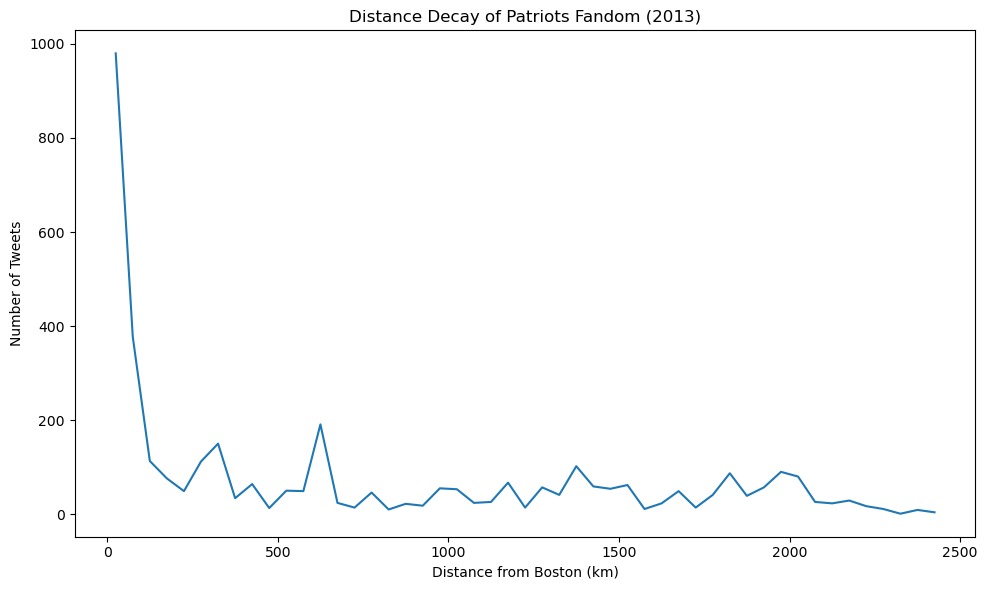

In [40]:
# radius of fandom
from shapely import Point

boston_center = Point(-71.0589, 42.3601)

# project tweets to meters
tweets_proj = tweets_with_city.to_crs(epsg=5070)  # NAD83 / Conus Albers

boston_proj = gpd.GeoSeries(
    [boston_center],
    crs="EPSG:4326"
).to_crs(epsg=5070).iloc[0]

tweets_proj["distance_km"] = (
    tweets_proj.geometry.distance(boston_proj) / 1000
)

bins = np.arange(0, 2500, 50)  # 0–2500 km in 50 km bins
tweets_proj["distance_bin"] = pd.cut(
    tweets_proj["distance_km"], bins=bins
)

distance_counts = (
    tweets_proj
    .groupby("distance_bin")
    .size()
    .reset_index(name="tweet_count")
)

# Get bin midpoints for plotting
distance_counts["bin_mid_km"] = (
    distance_counts["distance_bin"]
    .apply(lambda x: x.mid)
    .astype(float)
)


plt.figure(figsize=(10,6))
plt.plot(
    distance_counts["bin_mid_km"],
    distance_counts["tweet_count"]
)
plt.xlabel("Distance from Boston (km)")
plt.ylabel("Number of Tweets")
plt.title("Distance Decay of Patriots Fandom (2013)")
plt.show()



In [41]:
background_threshold = 1500

baseline = distance_counts[
    distance_counts["bin_mid_km"] > 1500
]["tweet_count"].mean()

radius_bg = distance_counts[
    distance_counts["tweet_count"] <= baseline
]["bin_mid_km"].iloc[0]

radius_bg

np.float64(375.0)

In [42]:
# Boston center (lat, lon)
boston_lat = 42.3601
boston_lon = -71.0589


R_km = radius_bg  # background-adjusted fandom radius

def geodesic_circle(lat, lon, radius_km, n_points=360):
    earth_radius_km = 6371.0
    angles = np.linspace(0, 2*np.pi, n_points)

    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)

    circle_lats = np.arcsin(
        np.sin(lat_rad) * np.cos(radius_km / earth_radius_km) +
        np.cos(lat_rad) * np.sin(radius_km / earth_radius_km) * np.cos(angles)
    )

    circle_lons = lon_rad + np.arctan2(
        np.sin(angles) * np.sin(radius_km / earth_radius_km) * np.cos(lat_rad),
        np.cos(radius_km / earth_radius_km) -
        np.sin(lat_rad) * np.sin(circle_lats)
    )

    return np.degrees(circle_lats), np.degrees(circle_lons)


circle_lat, circle_lon = geodesic_circle(
    boston_lat, boston_lon, R_km
)
metro_summary = tweets_with_city.groupby('NAME').agg({
    'id': 'count',
    'lat': 'mean',
    'lon': 'mean'
}).reset_index()

metro_summary = metro_summary.rename(columns={'id': 'count'})
metro_summary = metro_summary[metro_summary['count'] >= 10]

fig = px.scatter_geo(
    metro_summary,
    lat="lat",
    lon="lon",
    size="count",
    hover_name="NAME",
    hover_data={"count": True, "lat": False, "lon": False},
    title="Geographic Radius of Patriots Cowboys Fandom",
    scope="usa"
)


fig.add_trace(
    px.line_geo(
        lat=circle_lat,
        lon=circle_lon
    ).data[0]
)

fig.data[-1].update(
    line=dict(width=3, dash="dash"),
    name=f"Fandom radius ≈ {int(R_km)} km",
    showlegend=True
)

fig.add_trace(
    px.scatter_geo(
        lat=[boston_lat],
        lon=[boston_lon]
    ).data[0]
)

fig.data[-1].update(
    marker=dict(size=12),
    name="Boston"
)

fig.update_geos(
    scope="usa",
    showland=True,
    landcolor="lightgray",
    showocean=True,
    oceancolor="azure",
    showlakes=True,
    lakecolor="azure",
    showrivers=True,
    rivercolor="azure"
)

fig.update_layout(
    title_x=0.5,
    title_font_size=20,
    geo=dict(
        bgcolor='rgba(0,0,0,0)',
        landcolor='lightgray',
        lakecolor='azure'
    )
)

fig.show()

